In [1]:
import os.path as p
import warnings
warnings.filterwarnings("ignore")

import librosa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from python_speech_features import mfcc
from tqdm import tqdm

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
! ls

01-data-analysis.ipynb               __pycache__
02-spectograms-and-features.ipynb    clean
03-noise-detection-and-removal.ipynb downsample_remove_noise.py
04-data-sampling.ipynb               instruments.csv
README.md                            utils.py


In [3]:
# All recordings with the noise removed are stored in the local directory 'clean'

audio_data = pd.read_csv('instruments.csv')
DATA_DIR = 'clean'

In [4]:
def get_number_frames(filename):
    signal, sample_rate = librosa.load(p.join(DATA_DIR, filename), sr=None)
    return signal.shape[0]

audio_data['num_frames'] = audio_data.fname.apply(get_number_frames)
audio_data['length_sec'] = audio_data.num_frames / 16000

In [5]:
audio_data.head()

,fname,label,num_frames,length_sec
0,5388d14d.wav,Saxophone,66240,4.140000
1,c685f05f.wav,Saxophone,24640,1.540000
2,36d20ab5.wav,Saxophone,68947,4.309188
3,d6665734.wav,Saxophone,159476,9.967250
4,7352e28f.wav,Saxophone,99555,6.222188


# Sampling

In [6]:
label_avg_length = audio_data.groupby(audio_data.label).length_sec.mean()

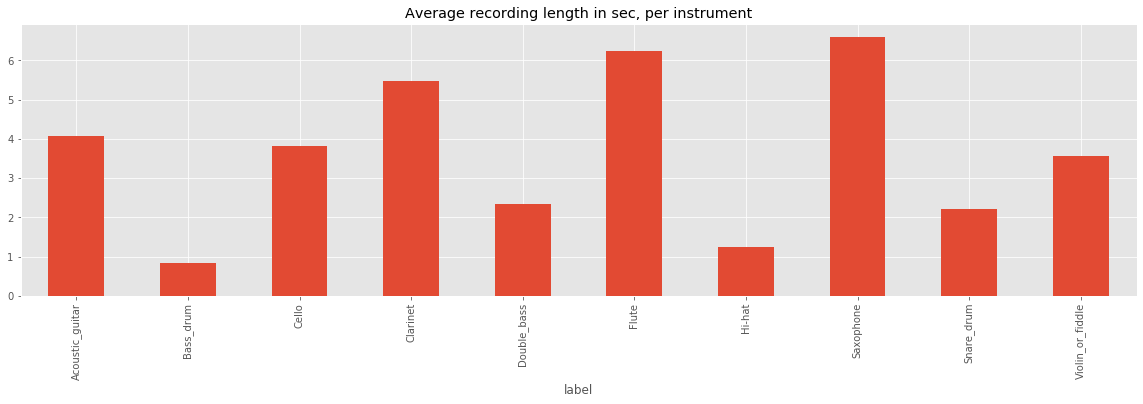

In [7]:
label_avg_length.plot.bar(figsize=(20, 5),
                          title="Average recording length in sec, per instrument")

In [8]:
label_distribution = label_avg_length / label_avg_length.sum()
label_distribution

label
Acoustic_guitar     0.112138
Bass_drum           0.022832
Cello               0.105020
Clarinet            0.150180
Double_bass         0.064431
Flute               0.171291
Hi-hat              0.034291
Saxophone           0.181171
Snare_drum          0.060866
Violin_or_fiddle    0.097781
Name: length_sec, dtype: float64

In [9]:
LABELS = list(audio_data.label.unique())
print(f"Available classes: {LABELS}")

label_idx = {label: i for i, label in enumerate(LABELS)}

Available classes: ['Saxophone', 'Violin_or_fiddle', 'Hi-hat', 'Snare_drum', 'Acoustic_guitar', 'Double_bass', 'Cello', 'Bass_drum', 'Flute', 'Clarinet']


> The probability to draw bass drum recording is 2.28%.

# Buld a random sample generator

**Sample size** 

**Normalization**

**Target label transformation**

In [10]:
total_length_audio = int(audio_data.length_sec.sum())
n_samples = int(2 * (total_length_audio / 0.1))

print(f"There are {total_length_audio} seconds of audio recordings. The number of available data samples is {n_samples}.")

There are 1092 seconds of audio recordings. The number of available data samples is 21840.


In [11]:
class Config(object):
    def __init__(self, mode='conv', nfilt=26, nfeat=13, 
                 nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate / 10.)
        
config = Config(mode='conv')

### The duration of a sample audio is set to 1/10 of a second. With sample rate of 16kHz this means 1600 frames. But what is the ratio of audio recordings with insufficient length?

In [12]:
audio_data[audio_data.num_frames < 1600]

,fname,label,num_frames,length_sec
118,4c4d4797.wav,Snare_drum,1516,0.09475


In [13]:
def normalize(matrix):
    normalized_matrix = (matrix - matrix.min()) / (matrix.max() - matrix.min())
    return normalized_matrix

def build_feature_target_matrix(config, label_dict):
    X = []
    y = []
    
    for _ in tqdm(range(n_samples)):
        # Choose a random instrument using the probability based on the audio length distribution
        random_instrument = np.random.choice(label_distribution.index, p=label_distribution)
        
        # Select a random file with equal probability to draw each of the 30 recordings
        random_file = np.random.choice(audio_data[audio_data.label == random_instrument].fname)
        signal, sample_rate = librosa.load(p.join(DATA_DIR, random_file), sr=None)

        # Select a starting frame, excluding the last n-steps frames in order to have full audio sample
        if signal.shape[0] > config.step: # exclude too short recordings
            last_possible_frame = signal.shape[0] - config.step
            random_start_frame = np.random.randint(0, last_possible_frame)
            sample_signal = signal[random_start_frame: random_start_frame + config.step]

            sample_mel = mfcc(sample_signal, sample_rate, numcep=config.nfeat, 
                              nfilt=config.nfilt, nfft=config.nfft)
            X.append(sample_mel)
            y.append(label_dict[random_instrument])
            
    features = normalize(np.array(X))
    targets = to_categorical(np.array(y), num_classes=len(label_dict))
    return features, targets

In [14]:
%%time

X, y = build_feature_target_matrix(config, label_idx)

100%|██████████| 21840/21840 [00:43<00:00, 506.72it/s]

CPU times: user 41 s, sys: 2.19 s, total: 43.2 s
Wall time: 43.2 s


In [15]:
print(X.shape)
print(y.shape)

(21805, 9, 13)
(21805, 10)
